# Fully Connected Experiments on FashionMNIST with a standardized setup


## 1. Setup

In [14]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import semitorch
import seaborn as sns

from collections import OrderedDict
from IPython import display
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load FashionMNIST data

In [15]:
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2. Models

In [16]:
def create_model(model_name: str, layer_norm: bool = False) -> nn.Sequential:
    stem = nn.Sequential(*filter(lambda x: x is not None, [
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=4),
        nn.Flatten(),
        nn.LayerNorm(8 * 7 * 7) if layer_norm else None,
        nn.Linear(8 * 7 * 7, 300),
    ]))

    if model_name == "linear/relu":
        backbone = nn.Sequential(
            nn.ReLU(),
            nn.Linear(300, 250), nn.ReLU(),
            nn.Linear(250, 200), nn.ReLU(),
            nn.Linear(200, 150), nn.ReLU(),
            nn.Linear(150, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
        )
    elif model_name == "linear/maxplus":
        backbone = nn.Sequential(
            semitorch.MaxPlus(300, 250),
            nn.Linear(250, 200),
            semitorch.MaxPlus(200, 150),
            nn.Linear(150, 100),
            semitorch.MaxPlus(100, 50),
        )
    elif model_name == "linear/minplus":
        backbone = nn.Sequential(
            semitorch.MinPlus(300, 250),
            nn.Linear(250, 200),
            semitorch.MinPlus(200, 150),
            nn.Linear(150, 100),
            semitorch.MinPlus(100, 50),
        )
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    head = nn.Linear(50, 10, bias=False)
    model = nn.Sequential(OrderedDict([("stem", stem), ("backbone", backbone), ("head", head)]))

    model.name = model_name

    return model


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_linear_model_parameters(model: nn.Sequential) -> nn.ParameterList:
    params = nn.ParameterList()

    for layer in model:
        if isinstance(layer, nn.Linear):
            params.extend(layer.parameters())
        if isinstance(layer, nn.Sequential):
            params.extend(get_linear_model_parameters(layer))

    return params


def get_semiring_model_parameters(model: nn.Sequential) -> nn.ParameterList:
    params = nn.ParameterList()

    for layer in model:
        if isinstance(layer, (semitorch.MaxPlus, semitorch.MinPlus)):
            params.extend(layer.parameters())
        if isinstance(layer, nn.Sequential):
            params.extend(get_semiring_model_parameters(layer))

    return params

## 3. Training

In [17]:
def accuracy(model: nn.Sequential, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Sequential, device: str, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Sequential, device: str, testloader: DataLoader) -> None:
    model.eval()

    conf_matrix = torch.zeros(len(testset.classes), len(testset.classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            conf_matrix[y.cpu(), prediction] += 1

    plt.figure(figsize=(6, 4))

    df_cm = pd.DataFrame(conf_matrix, index=testset.classes, columns=testset.classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train(
        model: nn.Sequential,
        device: str,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler] | None,
        loss: torch.nn.modules.loss,
        epochs: int,
) -> None:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6, 4])
    hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                if isinstance(optimizer, semitorch.TropicalSGD):
                    optimizer.step(input_tensor=x.cpu())
                else:
                    optimizer.step()
            if schedulers is not None:
                for scheduler in schedulers:
                    scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(-0.02, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.6 * epochs,
            0.30,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=10,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    confusion_matrix(model, device, testloader)

# Default Linear Models

linear/relu model has 294286 trainable parameters
linear/relu model has 295070 trainable parameters
Linear model with layer_norm=False


''

  0%|          | 0/20 [00:00<?, ?it/s]

Linear model with layer_norm=True


''

  0%|          | 0/20 [00:00<?, ?it/s]

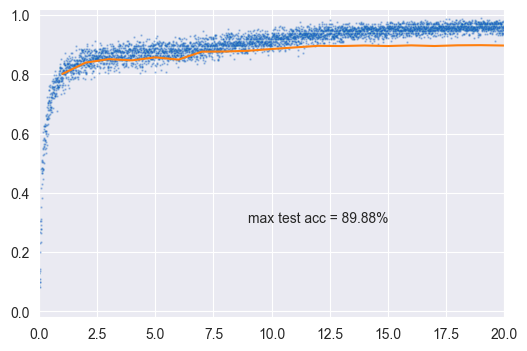

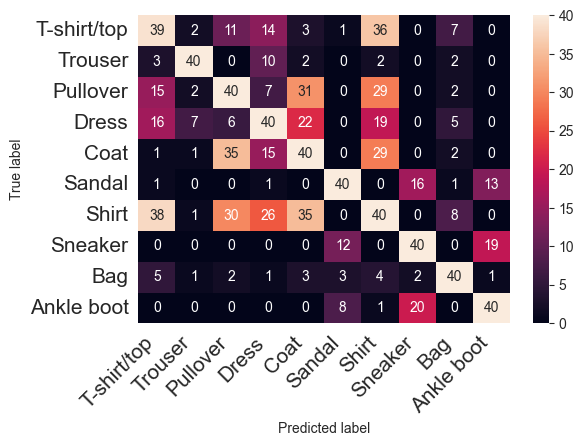

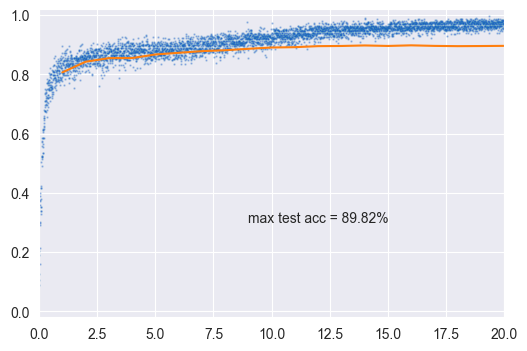

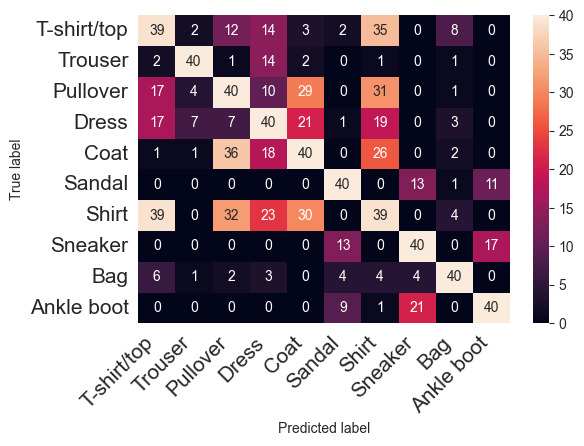

In [18]:
models = [
    create_model("linear/relu").to(device),
    create_model("linear/relu", layer_norm=True).to(device),
]

for model in models:
    print(f"{model.name} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for i, model in enumerate(models):
    if i == 0:
        print(f"Linear model with layer_norm=False")

        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
    elif i == 1:
        print(f"Linear model with layer_norm=True")

        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unexpected model")

    train(
        model,
        device,
        trainloader,
        testloader,
        [optimizer],
        [scheduler],
        loss,
        epochs,
    )

# Tropical models

Vanilla SGD with fixed learning rate

linear/maxplus model has 294286 trainable parameters, of which 183700 are linear and 110450 are semiring related
linear/minplus model has 294286 trainable parameters, of which 183700 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

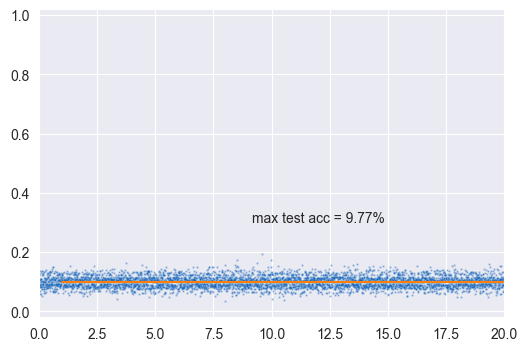

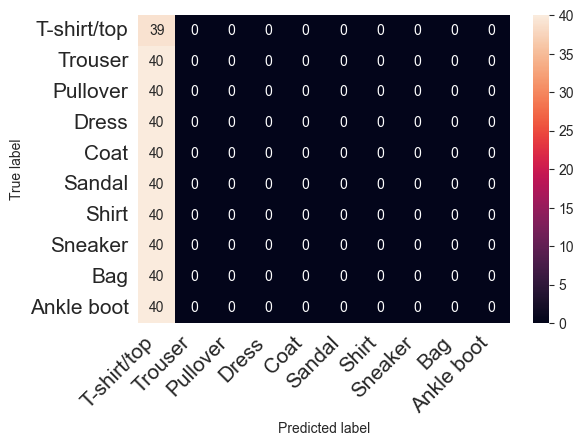

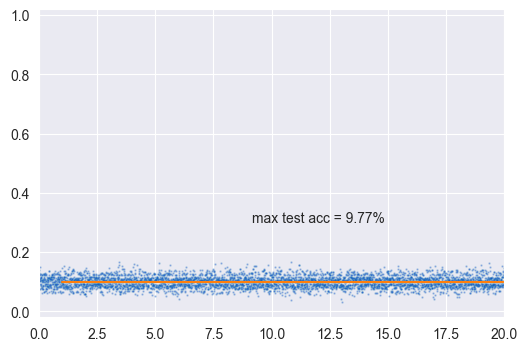

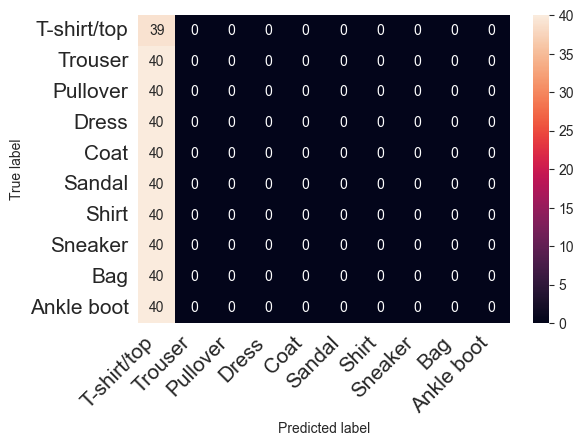

In [19]:
models = [
    create_model("linear/maxplus").to(device),
    create_model("linear/minplus").to(device),
]

for model in models:
    print(f"{model.name} model has {count_parameters(model)} trainable parameters, "
          f"of which {count_parameters(get_linear_model_parameters(model))} are linear "
          f"and {count_parameters(get_semiring_model_parameters(model))} are semiring related")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear/maxplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    elif model.name == "linear/minplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        optimizers,
        schedulers,
        loss,
        epochs,
    )

linear/maxplus model has 295070 trainable parameters, of which 183700 are linear and 110450 are semiring related
linear/minplus model has 295070 trainable parameters, of which 183700 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

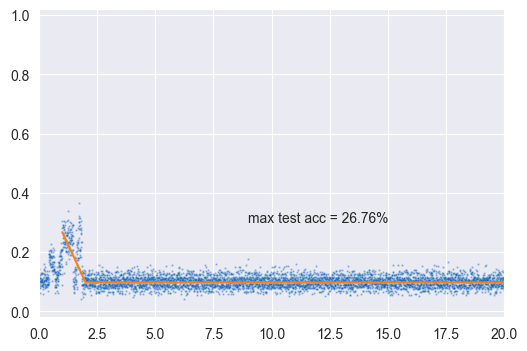

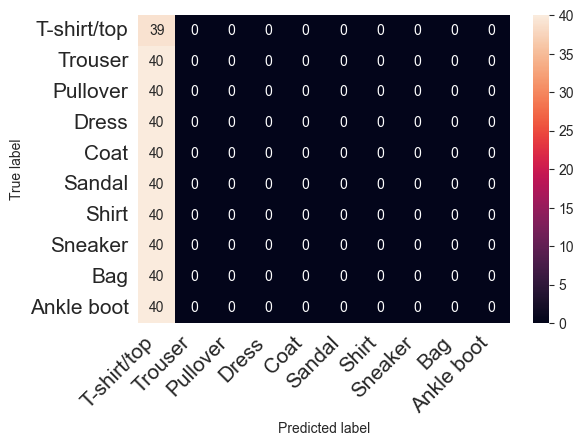

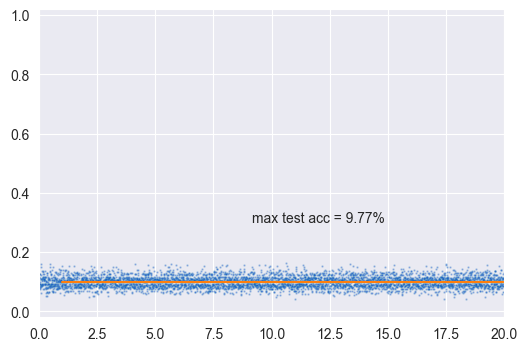

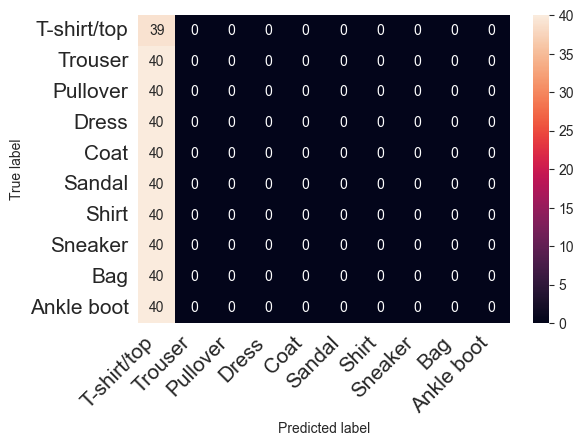

In [20]:
models = [
    create_model("linear/maxplus", layer_norm=True).to(device),
    create_model("linear/minplus", layer_norm=True).to(device),
]

for model in models:
    print(f"{model.name} model has {count_parameters(model)} trainable parameters, "
          f"of which {count_parameters(get_linear_model_parameters(model))} are linear "
          f"and {count_parameters(get_semiring_model_parameters(model))} are semiring related")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear/maxplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    elif model.name == "linear/minplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        optimizers,
        schedulers,
        loss,
        epochs,
    )

Compare with TropicalSGD

linear/maxplus model has 294286 trainable parameters, of which 183700 are linear and 110450 are semiring related
linear/minplus model has 294286 trainable parameters, of which 183700 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

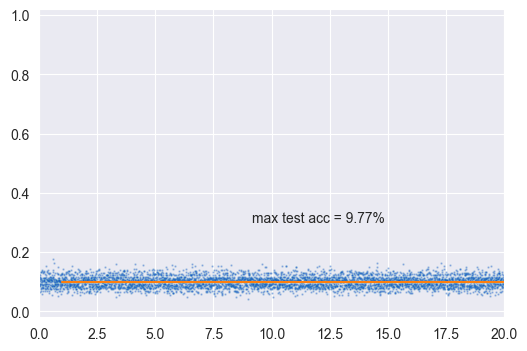

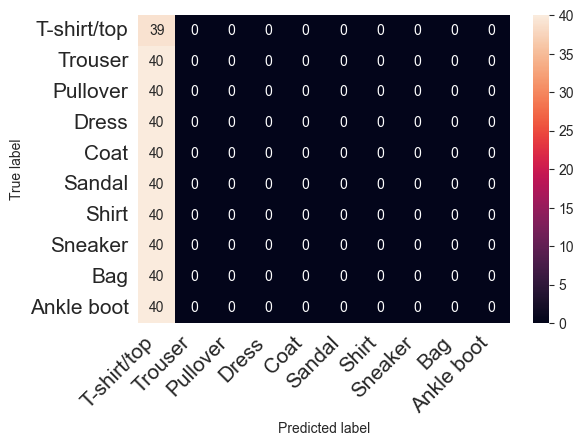

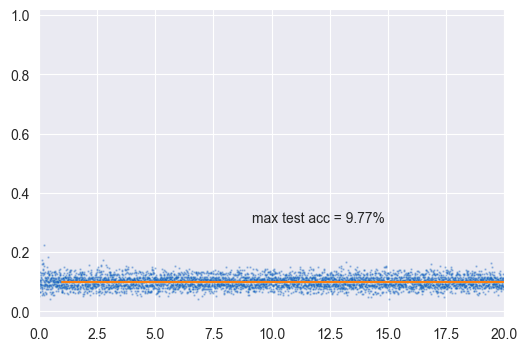

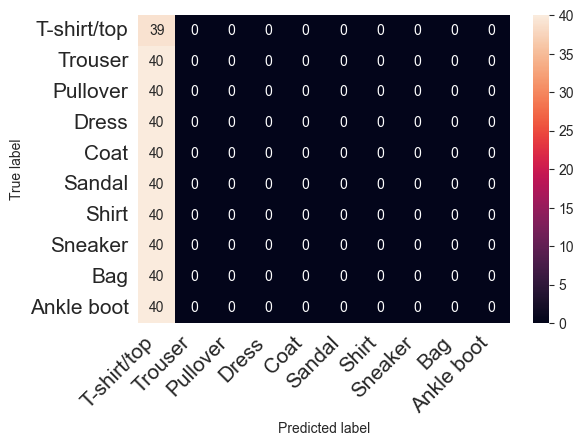

In [21]:
models = [
    create_model("linear/maxplus").to(device),
    create_model("linear/minplus").to(device),
]

for model in models:
    print(f"{model.name} model has {count_parameters(model)} trainable parameters, "
          f"of which {count_parameters(get_linear_model_parameters(model))} are linear "
          f"and {count_parameters(get_semiring_model_parameters(model))} are semiring related")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear/maxplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = semitorch.TropicalSGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    elif model.name == "linear/minplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = semitorch.TropicalSGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        optimizers,
        schedulers,
        loss,
        epochs,
    )

linear/maxplus model has 295070 trainable parameters, of which 183700 are linear and 110450 are semiring related
linear/minplus model has 295070 trainable parameters, of which 183700 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

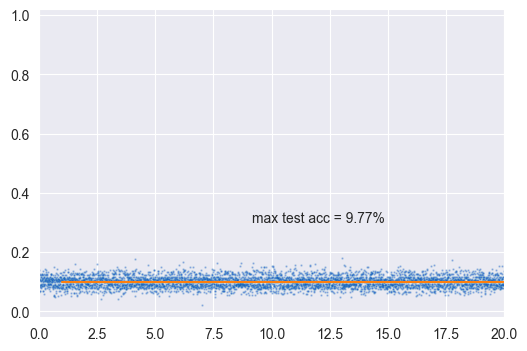

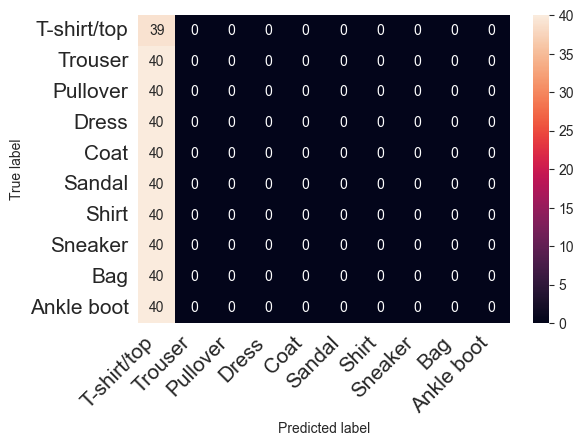

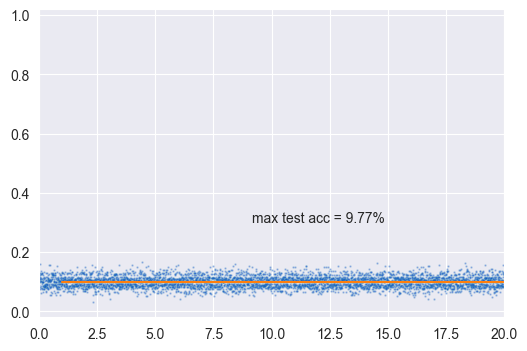

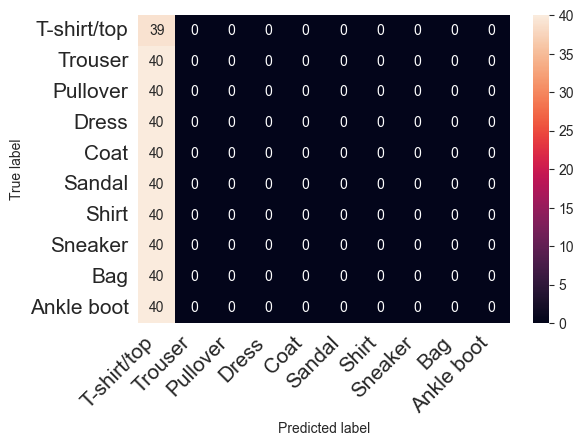

In [22]:
models = [
    create_model("linear/maxplus", layer_norm=True).to(device),
    create_model("linear/minplus", layer_norm=True).to(device),
]

for model in models:
    print(f"{model.name} model has {count_parameters(model)} trainable parameters, "
          f"of which {count_parameters(get_linear_model_parameters(model))} are linear "
          f"and {count_parameters(get_semiring_model_parameters(model))} are semiring related")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear/maxplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = semitorch.TropicalSGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    elif model.name == "linear/minplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = semitorch.TropicalSGD(get_semiring_model_parameters(model), lr=5e-2)
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler]
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        optimizers,
        schedulers,
        loss,
        epochs,
    )

Compare with custom learning rates